In [ ]:
import psutil

memory_info = psutil.virtual_memory()
print(f"Available RAM in GB: {memory_info.available / (1024 ** 3):.2f} GB")

Available RAM in GB: 56.82 GB


In [ ]:
import os


In [ ]:
ls

'20241025_124018(1)_1.jpg'   test/
 helper_functions.py         test-20241025T161949Z-001.zip
 __pycache__/                TINYVGG.ipynb
'Random pizza.png'           train/
'Random sushi.png'           train-20241025T162032Z-001.zip


## IMPORTING IMPORTANTS

In [ ]:
import helper_functions as hf
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import requests
import zipfile
from pathlib import Path
import os
import torch, torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import tqdm.auto as tqdm


# Setup Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/home/j215a/hello/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cpu'

In [ ]:
os.cpu_count()

20

## DATA PATHS

In [ ]:
from pathlib import Path

# Base Data Path
data_dir = Path("/home/j215a/Downloads/UGO")

# Path for train and test directories
train_dir = data_dir / "train"
test_dir = data_dir / "test"

print(train_dir, test_dir)


/home/j215a/Downloads/UGO/train /home/j215a/Downloads/UGO/test


## VIEW RANDOM IMAGE

In [ ]:
import random
from PIL import Image  # PIL is inbuilt in python

# Set seed
random.seed(42)

# 1. Get all image paths using glob and put it in a list
# Original: data_dir_list = list(data_dir.glob("*/*.jpg"))
# The original glob pattern only searches one level deep.
# We need to search recursively for all .jpg files.
data_dir_list = list(data_dir.rglob("**/*.jpg"))
# **/*.jpg searches all subdirectories for .jpg files.

# Check if the list is empty and handle the case
if not data_dir_list:
    raise ValueError("No .jpg files found in the specified directory. Please check the path and ensure images are present.")

# 2. Pick a random image path
random_data_dir = random.choice(data_dir_list)
print(random_data_dir)           # We got some lucky yummy sushi!!

# 3. Get the Image Class Name
random_image_class = random_data_dir.parent.stem   # parent = data/pizza_stake_sushi/test/pizza while .stem gives you the last folder which is pizza
print(random_image_class)

# 4. Open the image using PIL
img = Image.open(random_data_dir)              # If your image is corrupt, this might error
img

# 5. Print Image Metadata
print(f"Random Image Path: {random_data_dir}")
print(f"Random Image Class: {random_image_class}")
print(f"Image Size: {img.size}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
print(f"Image Format: {img.format}")           # Tells us whether its a JPEG, JPG or other image formats
print(f"Image Mode: {img.mode}")               # Tells us the color channels format

# PIL images dont have a shape attribute. You have to convert the image to a numpy array to get its shape

/home/j215a/Downloads/UGO/train/steak/1413972.jpg
steak
Random Image Path: /home/j215a/Downloads/UGO/train/steak/1413972.jpg
Random Image Class: steak
Image Size: (512, 512)
Image Height: 512
Image Width: 512
Image Format: JPEG
Image Mode: RGB


## DATA TRANSFORMS

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(300),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
        transforms.Resize((300, 300)),  # Resize images to match train size
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])



# Lets test it
img_tensor = train_transform(img)
img_tensor.shape, img_tensor.ndim, img_tensor.dtype


(torch.Size([3, 300, 300]), 3, torch.float32)

## VISUALIZE IMAGES

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.5528543].


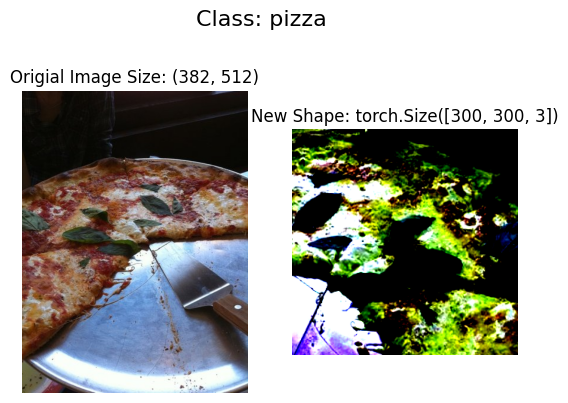

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..1.8508403].


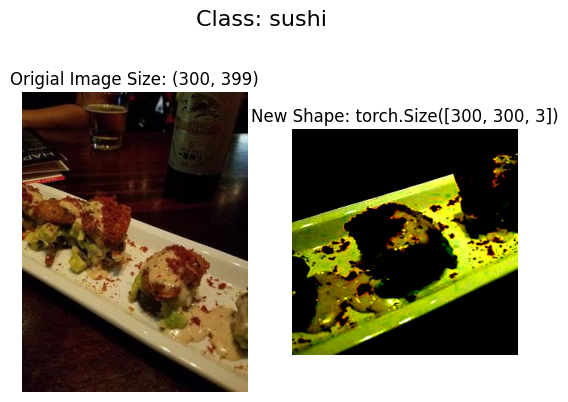

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


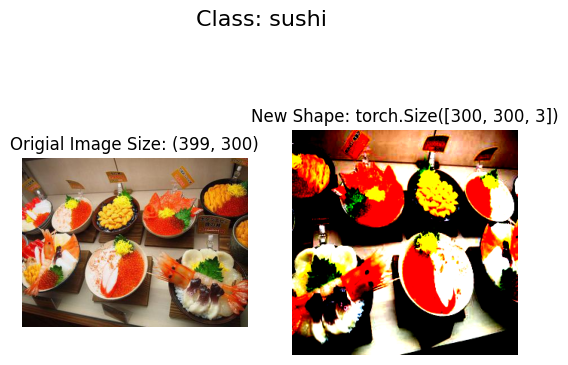

In [ ]:
def plot_transformed_images(data_dir, transform, n=3, seed=None):
  """
  Takes in an image path, transforms it and plots the original image beside
  the transformed image
  """
  if seed:
    random.seed(seed)
  else:
    random.seed(42)

  # Randomly sample n image paths from the image path. In this case, three images
  random_data_dirs = random.sample(data_dir, k=n)
  #Plot the image in the path
  for image_p in random_data_dirs:
    with Image.open(image_p) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Origial Image Size: {f.size}")    # RemebervPIL images dont have shape attributes
      ax[0].axis("off")

      # Transfor Image and Plot. Note: Matplotlib prefers color channels last unlike Pytorch which prefers first
      transformed_image = train_transform(f).permute(1,2,0)            # (C,H,W) --> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"New Shape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_p.parent.stem}",fontsize =16)
      plt.savefig(f"Random {image_p.parent.stem}.png")
      plt.show()


# Lets test our function
plot_transformed_images(data_dir_list, train_transform, n=3, seed=777)

## CREATING DATASET

In [ ]:

# Load Train and Test Data
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = train_transform,     # Transform train data
                                  target_transform = None)     # Transform labels. We dont need that because our labels are simply the stem of the parent file
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = test_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 937
     Root location: /home/j215a/Downloads/UGO/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(300, 300), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 140
     Root location: /home/j215a/Downloads/UGO/test
     StandardTransform
 Transform: Compose(
                Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [ ]:
# An advantage of using dataloaders is that it has useful attributes we can use
# We can get our labels as a list
class_names = train_data.classes
print(class_names)  # Beautiful.

# And also as a dictionary
class_dict = train_data.class_to_idx
print(class_dict)

# If you want to see all the labels of every train image in form 0, 1, 2
train_data.targets
# If you want to see the first pizza image directory
train_data.samples[0][0]
# If you want to see the first sushi image directory
train_data.samples[1][0]

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


'/home/j215a/Downloads/UGO/train/pizza/1008844.jpg'

## DATALOADER

In [ ]:
# Turn data into dataloader
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = os.cpu_count(),     # Number of GPU cores you have
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size= BATCH_SIZE,
                             num_workers = os.cpu_count(),
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fbee025d4b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fbeeca846a0>)

In [ ]:
# Our data loader should have the same length with our regular data since we set batch size to 1
print(len(train_dataloader), len(test_dataloader))
print(len(train_data), len(test_data))

30 5
937 140


## CUSTOM IMPROVED TINYVGG WITH 6 CONVOLUTION BLOCKS

In [ ]:
class ImprovedTinyVGG(nn.Module):
    """
    An optimized TinyVGG architecture with more filters and dynamic output size calculation.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        # Convolutional block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units*2,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2,
                      out_channels=hidden_units*2,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2,
                      out_channels=hidden_units*4,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*4,
                      out_channels=hidden_units*4,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional block 4
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4,
                      out_channels=hidden_units*8,  # increasing filters further
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*8,
                      out_channels=hidden_units*8,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional block 5
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*8,
                      out_channels=hidden_units*16,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*16,
                      out_channels=hidden_units*16,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional block 6
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*16,
                      out_channels=hidden_units*32,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*32,
                      out_channels=hidden_units*32,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 32 * 2 * 2 * 4, out_features = 32786), # out_features=256), # Assuming input images are 224x224
            nn.ReLU(),
            nn.Linear(in_features= 32786, out_features=output_shape)  # output size based on number of classes
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.conv_block6(x)
        x = self.classifier(x)
        return x


In [ ]:
# Remember that we had a trick to find out what should be our input shape in the classifier layer as we would always get an error
# To do that, we have to instantiate the model and run some dummy data through our model
model0 = ImprovedTinyVGG(input_shape = 3,
                  hidden_units = 64,
                  output_shape = len(train_data.classes)).to(device)

model0

ImprovedTinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [ ]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 300, 300]), torch.Size([32]))

In [ ]:
# Try the forward pass
model0(image_batch.to(device))

# It worked!!

tensor([[-0.0039,  0.0047,  0.0008],
        [-0.0039,  0.0047,  0.0008],
        [-0.0039,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0039,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0039,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0039,  0.0047,  0.0008],
        [-0.0039,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0039,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
        [-0.0039,  0.0047,  0.0008],
        [-0.0038,  0.0047,  0.0008],
 

## TRAINING

Epoch 1/200, Loss: 1.0998, Accuracy: 33.08%
Epoch 2/200, Loss: 1.0986, Accuracy: 34.36%
Epoch 3/200, Loss: 1.0926, Accuracy: 36.71%
Epoch 4/200, Loss: 1.0168, Accuracy: 48.56%
Epoch 5/200, Loss: 0.9695, Accuracy: 48.67%
Epoch 6/200, Loss: 0.9548, Accuracy: 53.15%
Epoch 7/200, Loss: 0.9027, Accuracy: 55.71%
Epoch 8/200, Loss: 0.9172, Accuracy: 55.92%
Epoch 9/200, Loss: 0.9091, Accuracy: 56.24%
Epoch 10/200, Loss: 0.8913, Accuracy: 55.07%
Epoch 11/200, Loss: 0.9093, Accuracy: 56.67%
Epoch 12/200, Loss: 0.9218, Accuracy: 54.54%
Epoch 13/200, Loss: 0.8742, Accuracy: 57.95%
Epoch 14/200, Loss: 0.8953, Accuracy: 53.79%
Epoch 15/200, Loss: 0.8718, Accuracy: 60.62%
Epoch 16/200, Loss: 0.8587, Accuracy: 59.55%
Epoch 17/200, Loss: 0.8509, Accuracy: 59.87%
Epoch 18/200, Loss: 0.8655, Accuracy: 61.15%
Epoch 19/200, Loss: 0.8293, Accuracy: 61.05%
Epoch 20/200, Loss: 0.8536, Accuracy: 59.87%
Epoch 21/200, Loss: 0.8204, Accuracy: 61.05%
Epoch 22/200, Loss: 0.8333, Accuracy: 64.25%
Epoch 23/200, Loss:

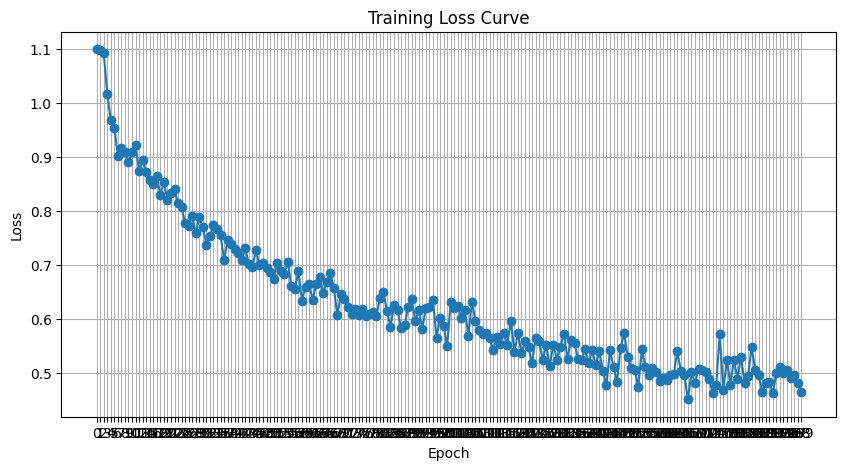

Test Loss: 0.4333, Test Accuracy: 85.00%


'\n# Optional: Save the model\ntorch.save(model.state_dict(), "tiny_vgg_model.pth")\nprint("Model saved!")\n'

In [ ]:
# Instantiate the model
input_shape = 3  # 3 for RGB images
hidden_units = 32
output_shape = 3  # 3 classes (pizza, steak, sushi)

model = ImprovedTinyVGG(input_shape=input_shape, hidden_units=hidden_units, output_shape=output_shape).to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6) #momentum=0.9,  # You can adjust the learning rate

# Modified training loop to store loss and accuracy values
def train_model(model, train_dataloader, loss_fn, optimizer, epochs=25):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    model.train()  # Set the model to training mode
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    epoch_losses = []  # List to store loss values for each epoch
    epoch_accuracies = []  # List to store accuracy values for each epoch
    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)  # Move data to the specified device

            # Forward pass
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            # Backward pass
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()  # Accumulate loss

            # Calculate accuracy
            _, predicted = torch.max(y_pred.data, 1)
            correct_predictions += (predicted == y).sum().item()
            total_samples += y.size(0)

        epoch_loss = running_loss / len(train_dataloader)
        epoch_accuracy = (correct_predictions / total_samples) * 100  # Calculate accuracy

        epoch_losses.append(epoch_loss)  # Store average loss for the epoch
        epoch_accuracies.append(epoch_accuracy)  # Store accuracy for the epoch
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    return epoch_losses, epoch_accuracies  # Return the list of losses and accuracies


#####################
#--------------------------------------------------------------------------------------------

# Train the model and get loss and accuracy values
loss_values, train_accuracies = train_model(model, train_dataloader, loss_fn, optimizer, epochs=200)
#--------------------------------------------------------------------------------------------

#####################



# Plotting the loss curve
plt.figure(figsize=(10, 5))
plt.plot(loss_values, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(loss_values)))  # Set x-ticks to be the epoch numbers
plt.grid()
plt.show()

# Evaluate the model
def evaluate_model(model, test_dataloader):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    model.eval()  # Set the model to evaluation mode
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    total, correct = 0, 0
    running_loss = 0.0  # To calculate test loss

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)  # Calculate loss

            running_loss += loss.item()  # Accumulate test loss

            _, predicted = torch.max(y_pred.data, 1)  # Get the index of the maximum predicted value
            total += y.size(0)                        # Total samples
            correct += (predicted == y).sum().item()  # Count correct predictions

    test_accuracy = 100 * correct / total
    test_loss = running_loss / len(test_dataloader)  # Average test loss
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

#####################
#--------------------------------------------------------------------------------------------

# Evaluate the model
evaluate_model(model, test_dataloader)

#####################
#--------------------------------------------------------------------------------------------
"""
# Optional: Save the model
torch.save(model.state_dict(), "tiny_vgg_model.pth")
print("Model saved!")
"""

## ACCURACY AND LOSS CURVES

In [ ]:
test_dir

PosixPath('/home/j215a/Downloads/UGO/test')

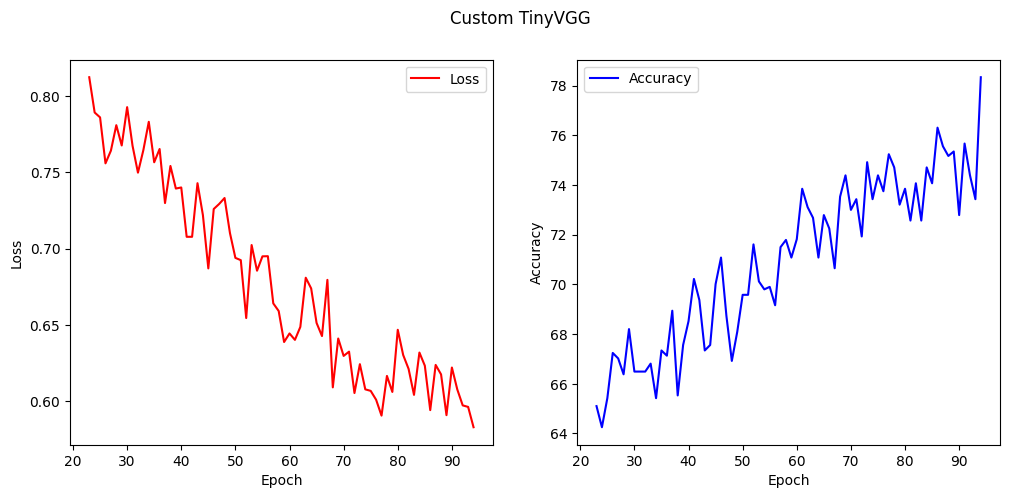

In [ ]:
import matplotlib.pyplot as plt

# Data extracted from the images
epochs = list(range(23, 100))
losses = [
    0.8122, 0.7891, 0.7859, 0.7558, 0.7641, 0.7808, 0.7675, 0.7926, 0.7673,
    0.7497, 0.7645, 0.7830, 0.7565, 0.7652, 0.7298, 0.7541, 0.7393, 0.7400,
    0.7077, 0.7077, 0.7428, 0.7219, 0.6870, 0.7259, 0.7292, 0.7331, 0.7101,
    0.6939, 0.6924, 0.6545, 0.7023, 0.6855, 0.6949, 0.6950, 0.6641, 0.6591,
    0.6388, 0.6444, 0.6402, 0.6487, 0.6809, 0.6739, 0.6513, 0.6427, 0.6795,
    0.6091, 0.6411, 0.6297, 0.6325, 0.6054, 0.6243, 0.6078, 0.6068, 0.6010,
    0.5906, 0.6166, 0.6061, 0.6468, 0.6303, 0.6212, 0.6042, 0.6319, 0.6233,
    0.5942, 0.6238, 0.6176, 0.5909, 0.6221, 0.6077, 0.5973, 0.5963, 0.5830,
    0.5909, 0.5891
]
accuracies = [
    65.10, 64.25, 65.42, 67.24, 67.02, 66.38, 68.20, 66.49, 66.49, 66.49,
    66.81, 65.42, 67.34, 67.13, 68.94, 65.53, 67.56, 68.52, 70.22, 69.37,
    67.34, 67.56, 70.01, 71.08, 68.73, 66.92, 68.09, 69.58, 69.58, 71.61,
    70.12, 69.80, 69.90, 69.16, 71.50, 71.79, 71.08, 71.82, 73.85, 73.11,
    72.68, 71.08, 72.79, 72.25, 70.65, 73.53, 74.39, 73.00, 73.43, 71.93,
    74.92, 73.43, 74.39, 73.75, 75.24, 74.71, 73.21, 73.85, 72.57, 74.07,
    72.57, 74.71, 74.07, 76.31, 75.56, 75.17, 75.35, 72.79, 75.67, 74.39,
    73.43, 78.34
]

# Find the minimum length of epochs, losses, and accuracies
min_length = min(len(epochs), len(losses), len(accuracies))

# Slice all lists to this minimum length
epochs = epochs[:min_length]
losses = losses[:min_length]
accuracies = accuracies[:min_length]

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label="Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label="Accuracy", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.suptitle("Custom TinyVGG")
plt.show()



## EVALUATE AND PLOT CONFUSION MATRIX

Note: you may need to restart the kernel to use updated packages.


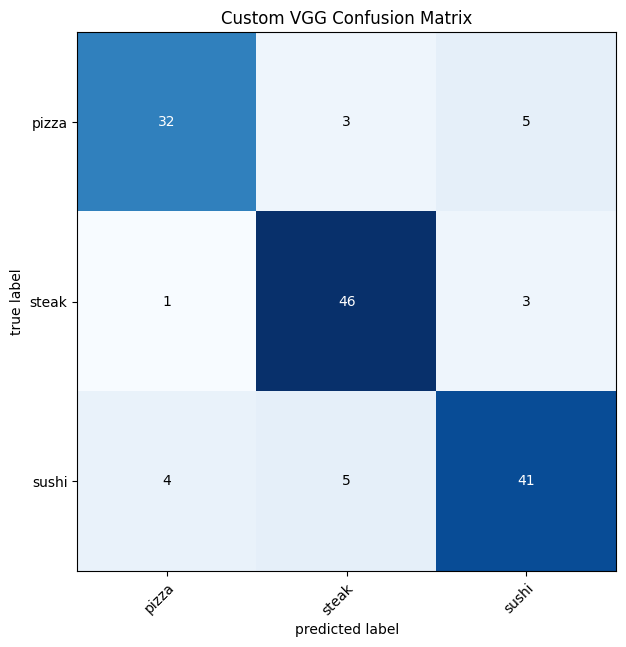

In [ ]:
%pip install mlxtend

import torch
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

def evaluate_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds_tensor = torch.tensor(all_preds)
    all_labels_tensor = torch.tensor(all_labels)

    confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
    confmat_tensor = confmat(preds=all_preds_tensor, target=all_labels_tensor)

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=(10, 7)
    )
    plt.title('Custom VGG Confusion Matrix')
    plt.savefig('Custom_VGG_Confusion_Matrix.png')
    plt.show()

evaluate_and_plot_confusion_matrix(model, test_dataloader, class_names)